In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(style='darkgrid')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_files = [
    'https://drive.google.com/uc?id=1U1UlEe_0NRzYYsw413bLvsQEdSQRbKcZ',
    'https://drive.google.com/uc?id=1I2aSktcMdoqzHV1mUjls_dFLeCbEjxqB',
    'https://drive.google.com/uc?id=1PnfXvUXFQtm87lkFKvW7xEETJXJFrgCt',
    'https://drive.google.com/uc?id=1NvYrlb8ccEALxHIbtv6PJIKr2LwhJGFx',
    'https://drive.google.com/uc?id=1Cq_U6sBUKGmJZFDGo8_IiC60EeZtv-bm',
    'https://drive.google.com/uc?id=1G3kBRv4xPVL3hnGkRulpgAH_5x3Z9IjY',
    'https://drive.google.com/uc?id=1Ji85nh8-f9F9kI2sEgoPhvredo38cdud',
    'https://drive.google.com/uc?id=1RR2a0J1aXa0DSv28OodLOxUW9TZGOjUu'
]
data = pd.concat([pd.read_csv(f) for f in data_files], ignore_index=True)

In [4]:
dups = data[data.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 143521


In [5]:
data.drop_duplicates(inplace = True)
data.shape

(1018692, 86)

In [6]:
# Làm sạch tên cột
data.columns = data.columns.str.strip()

In [7]:
# Xử lý giá trị vô cực và NaN
print(f'Initial missing values: {data.isna().sum().sum()}')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 7130925


<ipython-input-7-cebf0abe21a7>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace([np.inf, -np.inf], np.nan, inplace=True)


Missing values after processing infinite values: 7132350


In [8]:
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  6484.083927
Median of Flow Packets/s:  84.94372478


In [9]:
# Filling missing values with median
data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

<ipython-input-9-c500efc82597>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
<ipython-input-9-c500efc82597>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [10]:
print('Number of \'Flow Bytes/s\' missing values:', data['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', data['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


In [11]:
data['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

In [12]:
# Types of attacks & normal instances (BENIGN)
data['Label'].value_counts()

,count
Label,
BENIGN,795725
DDoS,128016
PortScan,90819
Bot,1953
Web Attack � Brute Force,1470
Web Attack � XSS,652
Infiltration,36
Web Attack � Sql Injection,21


In [13]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

In [14]:
data['Attack Type'].value_counts()

,count
Attack Type,
BENIGN,795725
DDoS,128016
Port Scan,90819
Web Attack,2143
Bot,1953
Infiltration,36


In [15]:
data.drop('Label', axis = 1, inplace = True)

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

print(data['Attack Number'].unique())

[0 2 4 1 3 5]


In [17]:
# Printing corresponding attack type for each encoded value
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: DDoS
3: Infiltration
4: Port Scan
5: Web Attack


In [18]:
# For improving performance and reduce memory-related errors
old_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            data[col] = data[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            data[col] = data[col].astype(np.int32)

new_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")

Initial memory usage: 683.94 MB
Final memory usage: 376.94 MB


In [19]:
# Calculating percentage reduction in memory usage
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Reduced memory usage: 44.89%


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018692 entries, 0 to 1162212
Data columns (total 87 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [21]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Destination Port,1018692.0,8.302926e+03,1.810117e+04,0.0,53.0,80.0,1311.00,65533.0
Flow Duration,1018692.0,1.191130e+07,3.026926e+07,-13.0,162.0,46500.0,2443960.25,119999992.0
Total Fwd Packets,1018692.0,8.718334e+00,6.622976e+02,1.0,1.0,2.0,4.00,207964.0
Total Backward Packets,1018692.0,9.736673e+00,8.876813e+02,0.0,1.0,2.0,4.00,284602.0
Total Length of Fwd Packets,1018692.0,6.360187e+02,1.473697e+04,0.0,6.0,52.0,102.00,12900000.0
...,...,...,...,...,...,...,...,...
"<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv=""content-type"" content=""text/html; charset=utf-8""/><style nonce=""CTZiQDQagd3b8h8rYiRMpw"">.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
".uc-warning-caption{color:#222;font-size:16px}#uc-download-link{text-decoration:none}.uc-name-size a{color:#15c;text-decoration:none}.uc-name-size a:visited{color:#61c;text-decoration:none}.uc-name-size a:active{color:#d14836;text-decoration:none}.uc-footer{color:#777;font-size:11px;padding-bottom:5ex;padding-top:5ex;text-align:center}.uc-footer a{color:#15c}.uc-footer a:visited{color:#61c}.uc-footer a:active{color:#d14836}.uc-footer-divider{color:#ccc;width:100%}.goog-inline-block{position:relative;display:-moz-inline-box;display:inline-block}* html .goog-inline-block{display:inline}*:first-child+html .goog-inline-block{display:inline}sentinel{}</style><link rel=""icon"" href=""//ssl.gstatic.com/docs/doclist/images/drive_2022q3_32dp.png""/></head><body><div class=""uc-main""><div id=""uc-dl-icon"" class=""image-container""><div class=""drive-sprite-aux-download-file""></div></div><div id=""uc-text""><p class=""uc-warning-caption"">Google Drive can't scan this file for viruses.</p><p class=""uc-warning-subcaption""><span class=""uc-name-size""><a href=""/open?id=1Ji85nh8-f9F9kI2sEgoPhvredo38cdud"">Tuesday-WorkingHours.pcap_ISCX.csv</a> (129M)</span> is too large for Google to scan for viruses. Would you still like to download this file?</p><form id=""download-form"" action=""https://drive.usercontent.google.com/download"" method=""get""><input type=""submit"" id=""uc-download-link"" class=""goog-inline-block jfk-button jfk-button-action"" value=""Download anyway""/><input type=""hidden"" name=""id"" value=""1Ji85nh8-f9F9kI2sEgoPhvredo38cdud""><input type=""hidden"" name=""confirm"" value=""t""><input type=""hidden"" name=""uuid"" value=""9dc03b00-44d5-4b26-8795-6576044ebddc""></form></div></div><div class=""uc-footer""><hr class=""uc-footer-divider""></div></body></html>",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv=""content-type"" content=""text/html; charset=utf-8""/><style nonce=""zMeXZe_xmZod_7ep6azssQ"">.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
".uc-warning-caption{color:#222;font-size:16px}#uc-download-link{text-decoration:none}.uc-name-size a{color:#15c;text-decoration:none}.uc-name-size a:visited{color:#61c;text-decoration:none}.uc-name-size a:active{color:#d14836;text-decoration:none}.uc-footer{color:#777;font-size:11px;padding-bottom:5ex;padding-top:5ex;text-align:center}.uc-footer a{color:#15c}.uc-footer a:visited{color:#61c}.uc-footer a:active{color:#d14836}.uc-footer-divider{color:#ccc;width:100%}.goog-inline-block{position:relative;display:-moz-inline-box;display:inline-block}* html .goog-inline-block{display:inline}*:first-child+html .goog-inline-block{display:inline}sentinel{}</style><link rel=""icon"" href=""//ssl.gstatic.com/docs/doclist/images/drive_2022q3_32dp.png""/></head><body><div class=""uc-main""><div id=""uc-dl-

In [22]:
# Dropping columns with only one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [23]:
data.shape

(1018692, 72)

In [24]:
# Columns after removing non variant columns
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

In [25]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = data.drop('Attack Type', axis = 1)
attacks = data['Attack Type']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [26]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.60%


In [27]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Attack Type'] = attacks.values

In [28]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,Attack Type
0,-1.874847,0.037669,-0.961831,1.308816,-0.637647,3.771686,0.154318,-0.586740,-0.293509,0.032258,...,0.312139,0.793199,-0.617238,-0.167164,-0.267660,-0.063761,-0.068019,0.121533,-0.079803,BENIGN
1,-1.684116,0.023605,-0.942678,1.397997,-0.786028,1.615093,-0.476738,1.197797,-2.050208,-0.078169,...,0.417912,0.962309,0.683946,0.403624,0.363415,0.019368,0.018369,-0.051478,-0.132519,BENIGN
2,-1.695971,0.024046,-0.949757,1.413961,-0.792028,1.702321,-0.443648,1.158715,-2.055396,-0.078764,...,0.405834,0.963723,0.674535,0.396293,0.360466,0.022332,0.018768,-0.052954,-0.133929,BENIGN
3,-1.703515,0.025101,-0.933922,1.312737,-0.736967,1.681596,-0.427565,1.111083,-1.963010,-0.073498,...,0.302073,0.598976,0.774171,0.343538,0.372535,0.010330,0.018803,-0.044877,-0.093538,BENIGN
4,-1.874848,0.037669,-0.961829,1.308790,-0.637649,3.771662,0.154287,-0.586736,-0.293489,0.032261,...,0.312083,0.793119,-0.617203,-0.167185,-0.267658,-0.063764,-0.068019,0.121544,-0.079791,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018687,-0.984266,0.252830,0.531377,-0.037762,0.889902,-0.656794,1.738596,-0.325901,0.010469,-0.071569,...,-0.290104,0.030367,-0.078692,0.381572,-0.244325,0.008243,-0.017770,0.255416,0.138194,BENIGN
1018688,-1.957447,0.052712,-0.711740,0.701608,-0.687476,1.085062,-0.160640,0.355178,-1.834208,-0.055385,...,0.717282,1.179395,-0.799878,0.756406,0.109735,0.141476,-0.020827,-0.546471,-0.440689,BENIGN
1018689,-1.642394,0.019877,-1.294611,1.971535,-1.130317,3.969930,-0.956084,-1.330372,1.598548,0.098068,...,-0.158583,1.141805,-0.481267,0.070863,0.078567,0.035086,0.376972,0.041364,0.047450,BENIGN
1018690,-0.997904,0.257976,0.493010,-0.022656,0.898861,-0.662421,1.745843,-0.322312,0.010623,-0.071840,...,-0.293121,0.023822,-0.083193,0.405584,-0.253016,0.000334,-0.021361,0.253205,0.149887,BENIGN


In [29]:
# For cross validation
from sklearn.model_selection import cross_val_score

In [30]:
new_data['Attack Type'].value_counts()

,count
Attack Type,
BENIGN,795725
DDoS,128016
Port Scan,90819
Web Attack,2143
Bot,1953
Infiltration,36


In [31]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

,count
Attack Type,
BENIGN,5000
DDoS,5000
Port Scan,5000
Web Attack,2143
Bot,1953


In [32]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

,count
Attack Type,
Port Scan,5000
DDoS,5000
Bot,5000
Web Attack,5000
BENIGN,5000


In [33]:
features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt1 = DecisionTreeClassifier(max_depth = 4)
dt1.fit(X_train, y_train)
y_pred_rf = dt1.predict(X_test)

cv_dt1 = cross_val_score(dt1, X_train, y_train, cv = 5)
print('Decision Tree Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt1)))
print(f'\nMean cross-validation score: {cv_dt1.mean():.2f}')
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Decision Tree Model 1

Cross-validation scores: 0.9685333333333334, 0.9714666666666667, 0.972, 0.9714666666666667, 0.98

Mean cross-validation score: 0.97
Accuracy: 0.97408
              precision    recall  f1-score   support

      BENIGN       0.94      0.94      0.94      1220
         Bot       0.95      0.96      0.95      1254
        DDoS       0.98      0.99      0.98      1273
   Port Scan       1.00      0.99      0.99      1288
  Web Attack       1.00      0.99      1.00      1215

    accuracy                           0.97      6250
   macro avg       0.97      0.97      0.97      6250
weighted avg       0.97      0.97      0.97      6250

[[1149   40   31    0    0]
 [  53 1200    0    1    0]
 [  16    0 1257    0    0]
 [   0   13    0 1275    0]
 [   0    8    0    0 1207]]


In [35]:
dt2 = DecisionTreeClassifier(max_depth = 6)
dt2.fit(X_train, y_train)
y_pred_rf = dt2.predict(X_test)

cv_dt2 = cross_val_score(dt2, X_train, y_train, cv = 5)
print('Decision Tree Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt2)))
print(f'\nMean cross-validation score: {cv_dt2.mean():.2f}')
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Decision Tree Model 2

Cross-validation scores: 0.9909333333333333, 0.9893333333333333, 0.9949333333333333, 0.9882666666666666, 0.996

Mean cross-validation score: 0.99
Accuracy: 0.9936
              precision    recall  f1-score   support

      BENIGN       1.00      0.98      0.99      1220
         Bot       0.99      1.00      0.99      1254
        DDoS       0.99      1.00      1.00      1273
   Port Scan       0.99      1.00      1.00      1288
  Web Attack       1.00      0.99      1.00      1215

    accuracy                           0.99      6250
   macro avg       0.99      0.99      0.99      6250
weighted avg       0.99      0.99      0.99      6250

[[1194   17    9    0    0]
 [   4 1250    0    0    0]
 [   1    0 1272    0    0]
 [   0    1    0 1287    0]
 [   0    0    0    8 1207]]


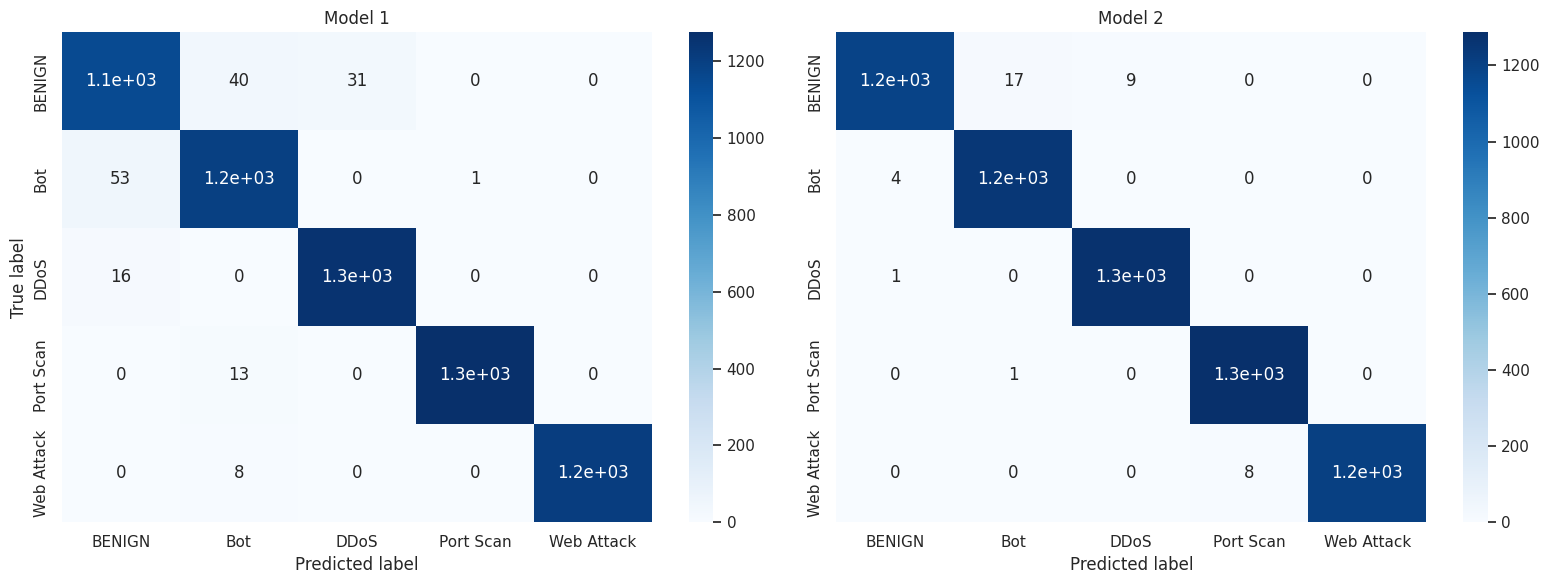

In [36]:
y_pred_dt1 = dt1.predict(X_test)
y_pred_dt2 = dt2.predict(X_test)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_dt1)
conf_matrix_model2 = confusion_matrix(y_test, y_pred_dt2)

fig, axs = plt.subplots(1, 2, figsize = (16, 6))

sns.heatmap(conf_matrix_model1, annot = True, cmap = 'Blues', ax = axs[0], xticklabels = dt1.classes_, yticklabels = dt1.classes_)
axs[0].set_title('Model 1')

sns.heatmap(conf_matrix_model2, annot = True, cmap = 'Blues', ax = axs[1], xticklabels = dt2.classes_, yticklabels = dt2.classes_)
axs[1].set_title('Model 2')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()
plt.show()

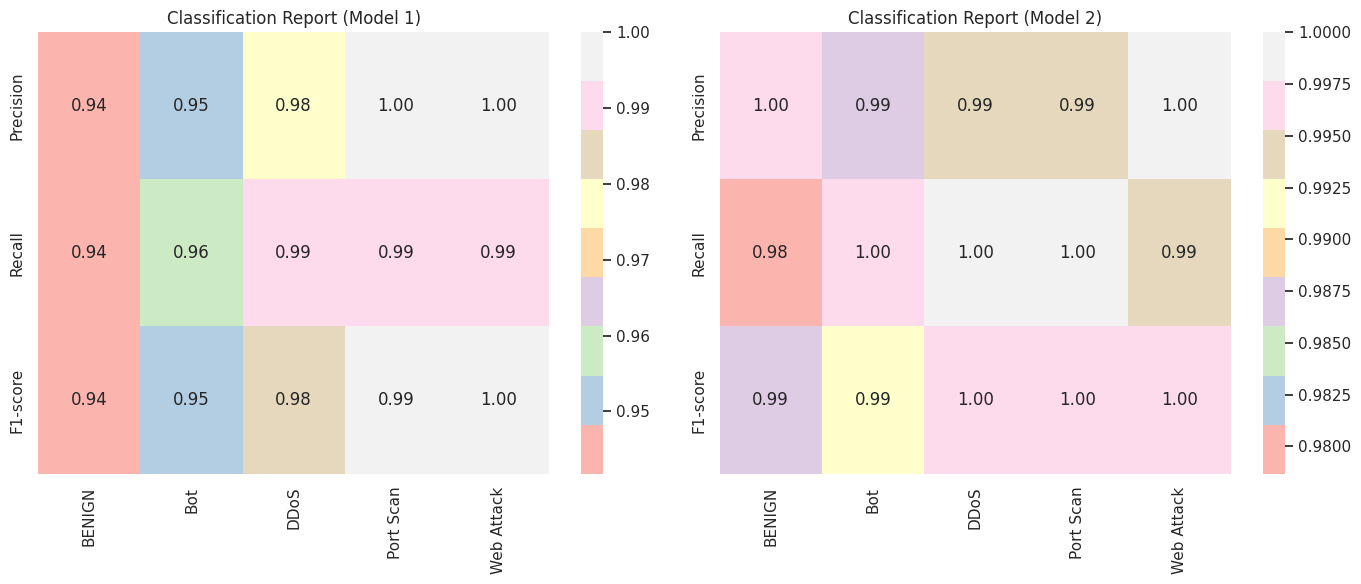

In [37]:
target_names = dt1.classes_
metrics1 = classification_report(y_true = y_test, y_pred = y_pred_dt1, target_names = target_names, output_dict = True)
precision1 = [metrics1[target_name]['precision'] for target_name in target_names]
recall1 = [metrics1[target_name]['recall'] for target_name in target_names]
f1_score1 = [metrics1[target_name]['f1-score'] for target_name in target_names]

metrics2 = classification_report(y_true = y_test, y_pred = y_pred_dt2, target_names = target_names, output_dict = True)
precision2 = [metrics2[target_name]['precision'] for target_name in target_names]
recall2 = [metrics2[target_name]['recall'] for target_name in target_names]
f1_score2 = [metrics2[target_name]['f1-score'] for target_name in target_names]

data1 = np.array([precision1, recall1, f1_score1])
data2 = np.array([precision2, recall2, f1_score2])
rows = ['Precision', 'Recall', 'F1-score']

fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.heatmap(data1, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[0])
sns.heatmap(data2, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[1])
axs[0].set_title('Classification Report (Model 1)')
axs[1].set_title('Classification Report (Model 2)')
fig.tight_layout()
plt.show()

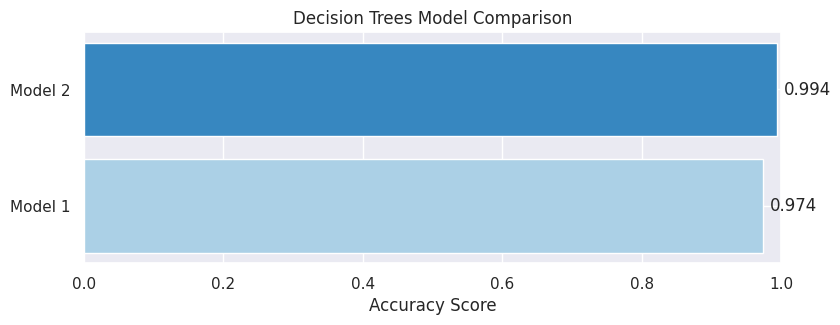

In [38]:
palette = sns.color_palette('Blues', n_colors = 2)

acc1 = accuracy_score(y_pred_dt1, y_test)
acc2 = accuracy_score(y_pred_dt2, y_test)

labels = ['Model 1', 'Model 2']
scores = [acc1, acc2]

fig, ax = plt.subplots(figsize = (9, 3))
ax.barh(labels, scores, color = palette)
ax.set_xlim([0, 1])
ax.set_xlabel('Accuracy Score')
ax.set_title('Decision Trees Model Comparison')

for i, v in enumerate(scores):
    ax.text(v + 0.01, i, str(round(v, 3)), ha = 'left', va = 'center')

plt.show()

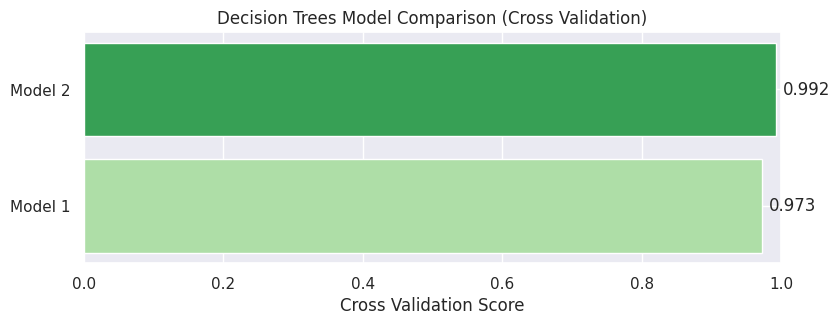

In [39]:
palette = sns.color_palette('Greens', n_colors = 2)

labels = ['Model 1', 'Model 2']
scores = [cv_dt1.mean(), cv_dt2.mean()]

fig, ax = plt.subplots(figsize = (9, 3))
ax.barh(labels, scores, color = palette)
ax.set_xlim([0, 1])
ax.set_xlabel('Cross Validation Score')
ax.set_title('Decision Trees Model Comparison (Cross Validation)')

for i, v in enumerate(scores):
    ax.text(v + 0.01, i, str(round(v, 3)), ha = 'left', va = 'center')

plt.show()